In [31]:
library(netSmooth)
library(pheatmap)
library(Rtsne)
# http://htmlpreview.github.io/?https://github.com/BIMSBbioinfo/netSmooth/blob/master/vignettes/netSmoothIntro.html

In [25]:
data(smallPPI)
data(smallscRNAseq)

In [26]:
anno.df <- data.frame(cell.type=colData(smallscRNAseq)$source_name_ch1)
rownames(anno.df) <- colnames(smallscRNAseq)

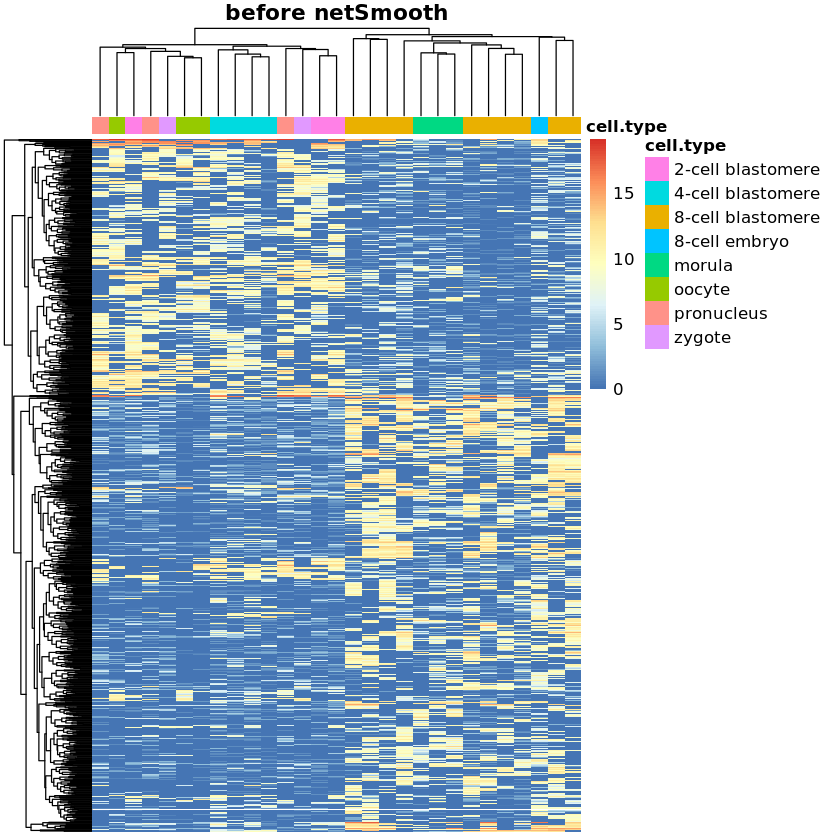

In [27]:
pheatmap(log2(assay(smallscRNAseq)+1), annotation_col = anno.df,
         show_rownames = FALSE, show_colnames = FALSE,
         main="before netSmooth")

In [ ]:
## Apply netSmooth with alpha = 0.5
smallscRNAseq.sm.se <- netSmooth(smallscRNAseq, smallPPI, alpha=0.5)
smallscRNAseq.sm.sce <- SingleCellExperiment(
    assays=list(counts=assay(smallscRNAseq.sm.se)),
    colData=colData(smallscRNAseq.sm.se)
)

pheatmap(log2(assay(smallscRNAseq.sm.sce)+1), annotation_col = anno.df,
         show_rownames = FALSE, show_colnames = FALSE,
         main="after netSmooth")

Picked dimReduceFlavor: tsne
Picked alpha=0.3


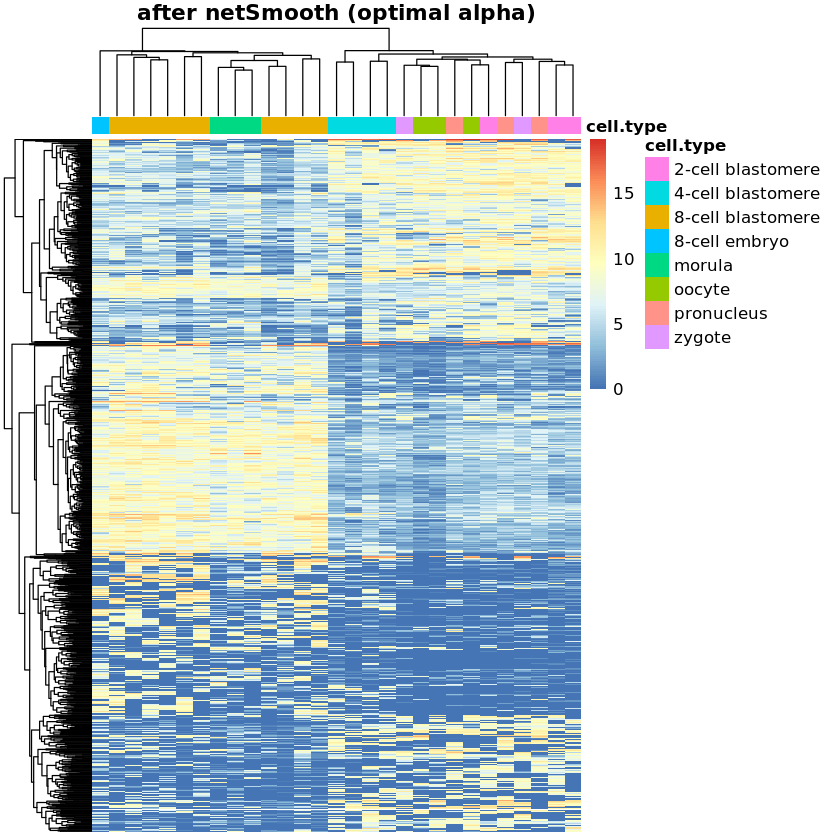

In [34]:
### netSmooth with automatic dimension reduction
smallscRNAseq.sm.se <- netSmooth(smallscRNAseq, smallPPI, alpha='auto')

smallscRNAseq.sm.sce <- SingleCellExperiment(
    assays=list(counts=assay(smallscRNAseq.sm.se)),
    colData=colData(smallscRNAseq.sm.se)
)

pheatmap(log2(assay(smallscRNAseq.sm.sce)+1), annotation_col = anno.df,
         show_rownames = FALSE, show_colnames = FALSE,
         main="after netSmooth (optimal alpha)")

In [47]:
# Robust clustering
## Not one method can be used for all data since different data have different topologies that
## respond differently to clustering algos, so we must tailor the clustering to our analysis.

## Here we use *clusterExperiment*, which uses consensus clustering of different views of the
## obtained from different clustering strategies

## The robustClusters method works by reducing the dimension of the dataset
## and comparing different dimensional reduction strategies by measuring
## the resulting entropy of the dataset.
yhat <- robustClusters(smallscRNAseq, combineManyMinSize=2, combineManyProportion=.9)$clusters
yhat.sm <- robustClusters(smallscRNAseq.sm.se, combineManyMinSize=2, combineManyProportion=.9)$clusters

Picked dimReduceFlavor: tsne
Note: Merging will be done on ' combineMany ', with clustering index 1 
Picked dimReduceFlavor: pca
Note: Merging will be done on ' combineMany ', with clustering index 1 


Warning message:
“Zero sample variances detected, have been offset away from zero”

In [41]:
cell.types <- colData(smallscRNAseq)$source_name_ch1
knitr::kable(
  table(cell.types, yhat), caption = 'Cell types and `robustClusters` in the raw data.'
)
knitr::kable(
  table(cell.types, yhat.sm), caption = 'Cell types and `robustClusters` in the smoothed data.'
)
## Cluster assignment of -1 means that the cell could not be placed in a robust cluster, and so
## is omitted

## The (top) raw data shows that quite a few clusters are uninformative: 
##    some of the 8-cell bastomeres are clustered with the morula cells

## However the (bottom) smoothed data shows that the 8-cell bastometeres actually inhabit a 
## cluster of their own



|                  | -1|  1|  2|
|:-----------------|--:|--:|--:|
|2-cell blastomere |  0|  3|  0|
|4-cell blastomere |  3|  1|  0|
|8-cell blastomere |  7|  0|  3|
|8-cell embryo     |  1|  0|  0|
|morula            |  0|  0|  3|
|oocyte            |  1|  2|  0|
|pronucleus        |  3|  0|  0|
|zygote            |  1|  1|  0|



|                  | -1|  1|  2|  3|
|:-----------------|--:|--:|--:|--:|
|2-cell blastomere |  1|  2|  0|  0|
|4-cell blastomere |  2|  2|  0|  0|
|8-cell blastomere |  6|  0|  4|  0|
|8-cell embryo     |  1|  0|  0|  0|
|morula            |  0|  0|  0|  3|
|oocyte            |  0|  3|  0|  0|
|pronucleus        |  1|  2|  0|  0|
|zygote            |  0|  2|  0|  0|

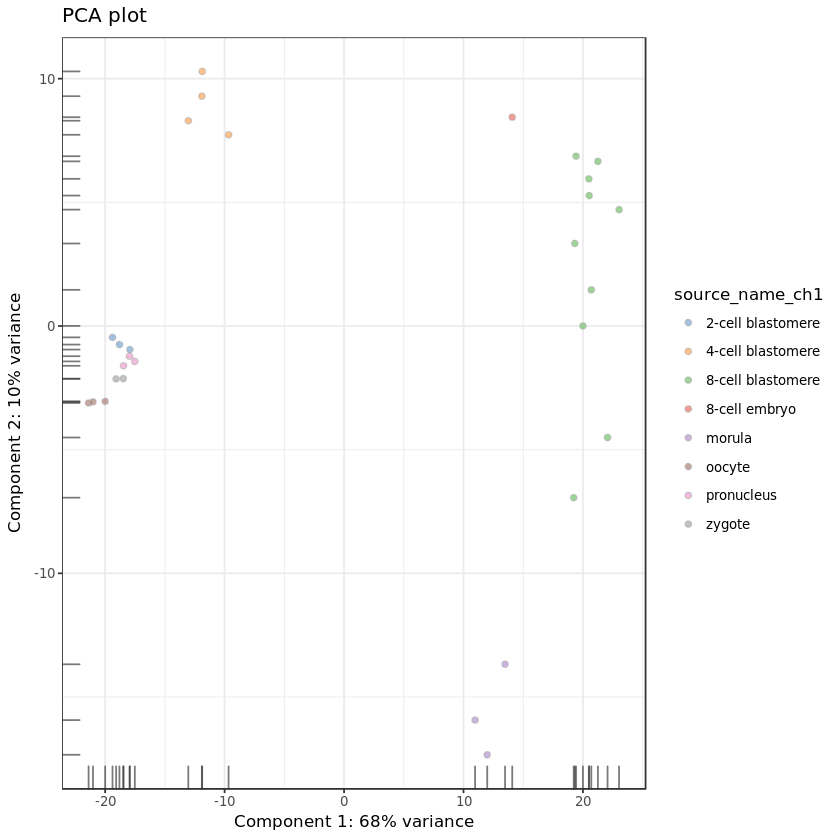

[1] "tsne"

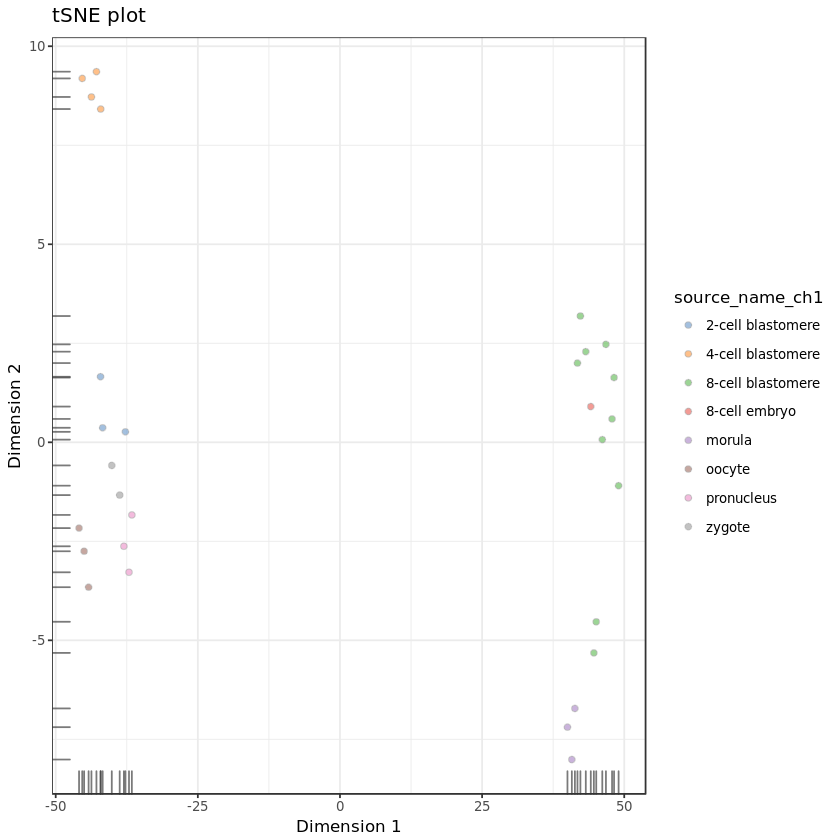

In [49]:
## Let's compare different Dim reduction strategies: PCA and tSNE

plotPCA(smallscRNAseq, colour_by='source_name_ch1') + ggtitle("PCA plot")
plotTSNE(smallscRNAseq, colour_by='source_name_ch1') + ggtitle("tSNE plot")

## And which one has a higher 2D entropy?
## robustClusters uses pickDimReduction to measure this
pickDimReduction(smallscRNAseq)

In [51]:
require(STRINGdb)
require(igraph)
require(biomaRt)

Loading required package: STRINGdb
Loading required package: igraph

Attaching package: ‘igraph’

The following object is masked from ‘package:scater’:

    normalize

The following object is masked from ‘package:GenomicRanges’:

    union

The following object is masked from ‘package:IRanges’:

    union

The following object is masked from ‘package:S4Vectors’:

    union

The following objects are masked from ‘package:BiocGenerics’:

    normalize, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [54]:
## 2.

## StringDB has (gene?) networks from many species. We can prune this network
## for our purposes to give those that are of high confidence and of interest
## to us via netSmooth

string_db <- STRINGdb$new(species=9606) # human
human_graph <- string_db$get_graph()

# Grab edges with high confidences
edge.scores <- E(human_graph)$combined_score
ninetyth.percentile <- quantile(edge.scores,0.9)
thresh <- data.frame(name='90th percentile', val=ninetyth.percentile)

In [61]:
human_graph <- subgraph.edges(human_graph, E(human_graph)[combined_score > ninetyth.percentile])

In [64]:
# create adjacency matrix
adj_matrix <- as_adjacency_matrix(human_graph)

In [65]:
### get gene/protein ids via Biomart
mart=useMart(host = 'grch37.ensembl.org',
        biomart='ENSEMBL_MART_ENSEMBL',
        dataset='hsapiens_gene_ensembl') 

### extract protein ids from the human network
protein_ids <- sapply(strsplit(rownames(adj_matrix), '\\.'),
                          function(x) x[2])

### get protein to gene id mappings
mart_results <- getBM(attributes = c("ensembl_gene_id",
                                         "ensembl_peptide_id"),
    filters = "ensembl_peptide_id", values = protein_ids,
    mart = mart)

### replace protein ids with gene ids
ix <- match(protein_ids, mart_results$ensembl_peptide_id)
ix <- ix[!is.na(ix)]

newnames <- protein_ids
newnames[match(mart_results[ix,'ensembl_peptide_id'], newnames)] <-
        mart_results[ix, 'ensembl_gene_id']
rownames(adj_matrix) <- newnames
colnames(adj_matrix) <- newnames

ppi <- adj_matrix[!duplicated(newnames), !duplicated(newnames)]
nullrows <- Matrix::rowSums(ppi)==0
ppi <- ppi[!nullrows,!nullrows] ## ppi is the network with gene ids